In [1]:
import midynet
import midynet.util.display as display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pathlib
import numpy as np
import fractions


plot = midynet.metrics.Statistics.plot

display.setup_dir("./")

paths_to_figures = [".", "../../../../papers/p-midynet/paper1-mutual_info/figures"]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))

## Loading data from experiment

In [2]:


exp = {}
bit_ratio = np.log(2)
hg, hx, hgx, hxg, mi = {}, {}, {}, {}, {}

all_dynamics = ["ising", "sis", "cowan"]
for dynamics in all_dynamics:
    path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure2/exact-{dynamics}/")
    if (path_to_data / "config.pickle").exists():
        exp[dynamics] = midynet.experiments.Experiment.load_from_file(path_to_data / "config.pickle")
        hg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hg-{k}"] for k in ["mid", "high", "low"]})
        hx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hx-{k}"] for k in ["mid", "high", "low"]})
        hgx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hgx-{k}"] for k in ["mid", "high", "low"]})
        hxg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hxg-{k}"] for k in ["mid", "high", "low"]})
        mi[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"mi-{k}"] for k in ["mid", "high", "low"]})

xlabel = r"Number of time steps"
titles = {"ising": r"Glauber", "sis": r"SIS", "cowan": r"Cowan"}
couplingLabels = {"ising": r"J\langle k \rangle", "sis": r"\lambda \langle k \rangle", "cowan": r"\nu\langle k \rangle"}

## Figure 2 revisited

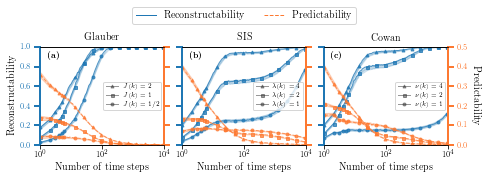

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(7,7/3), sharex=True, sharey=True)

ax = {dynamics: ax[i] for i, dynamics in enumerate(all_dynamics)}
axx = {dynamics: ax[dynamics].twinx() for i, dynamics in enumerate(all_dynamics)}


recon_color = display.med_colors["blue"]
pred_color = display.dark_colors["orange"]


spacing = 7
min_index = 5
recon_yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
pred_yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

markers = ["o", "s", "^", "*"]
for dynamics_id, dynamics in enumerate(all_dynamics):
    if dynamics not in exp:
        continue
    x = np.array(exp[dynamics].config.dynamics.num_steps)
    m_indices = list(range(min_index)) + list(range(min_index, len(x), spacing))
    coupling = exp[dynamics].config.dynamics.get_coupling()
    if dynamics == "sis":
        coupling = [c / exp[dynamics].config.dynamics.recovery_prob for c in coupling]
    alpha = np.linspace(0, 1, len(coupling) + 2)[2:] ** 1.5
    recon = mi[dynamics] / hg[dynamics]
    pred = mi[dynamics] / hx[dynamics]
    for c_index, (c, a) in reversed(list(enumerate(zip(coupling, alpha)))):
        
        y = recon if len(coupling) == 1 else recon[:, c_index]
        plot(
            ax[dynamics], 
            x, y,
            color=recon_color,
            alpha=0.75,
            linestyle="-",
            marker="None",
            linewidth=1,
        )
        y = recon[m_indices] if len(coupling) == 1 else recon[m_indices, c_index]
        plot(
            ax[dynamics], 
            x[m_indices], y,
            color=recon_color,
            alpha=0.75,
            linestyle="None",
            marker=markers[c_index],
            markersize=3,
        )
        
        
        y = pred if len(coupling) == 1 else pred[:, c_index]
        plot(
            axx[dynamics], 
            x, y,
            color=pred_color,
            alpha=0.75,
            linestyle="--",
            linewidth=1,
            marker="None",
        )
        y = pred[m_indices] if len(coupling) == 1 else pred[m_indices, c_index]
        plot(
            axx[dynamics], 
            x[m_indices], y,
            color=pred_color,
            alpha=0.75,
            linestyle="None",
            marker=markers[c_index],
            markersize=3,
        )
    
    if dynamics_id == 0:
        ax[dynamics].set_ylabel(r"Reconstructability", fontsize=display.fontsizes["large"])
        ax[dynamics].set_yticks(recon_yticks)
#         ax[dynamics].set_yticklabels([fractions.Fraction(x).limit_denominator() for x in recon_yticks])
        
    if dynamics_id == len(all_dynamics)-1:
        axx[dynamics].set_ylabel(r"Predictability", fontsize=display.fontsizes["large"], rotation=-90, rotation_mode="anchor", va="bottom")
        axx[dynamics].set_yticks(pred_yticks)
#         axx[dynamics].set_yticklabels([fractions.Fraction(x).limit_denominator() for x in pred_yticks])
    else:
        axx[dynamics].axes.xaxis.set_ticklabels([])
        axx[dynamics].axes.yaxis.set_ticklabels([])
    ax[dynamics].set_xlabel(xlabel, fontsize=display.fontsizes["large"])
    ax[dynamics].tick_params(axis='both', labelsize=display.fontsizes["medium"])
    ax[dynamics].set_xlim([1, 1000])
    ax[dynamics].set_ylim([0., 1.])
    ax[dynamics].set_xscale("log")
    ax[dynamics].set_title(titles[dynamics], fontsize=display.fontsizes["large"])
    
    axx[dynamics].set_xlabel(xlabel, fontsize=display.fontsizes["large"])
    axx[dynamics].tick_params(axis='both', labelsize=display.fontsizes["medium"])
    axx[dynamics].set_xlim([1, 1e4])
    axx[dynamics].set_xscale("log")
    axx[dynamics].set_ylim([0, 0.5])
    
    handles = [
        Line2D(
            [0], [0], 
            marker=markers[i], 
            linestyle="-", 
            color=display.dark_colors["grey"], 
            label=rf"${couplingLabels[dynamics]} = {fractions.Fraction(c)}$", 
            alpha=0.5,
            markersize=3,
            linewidth=1,
        )
        for i, c in reversed(list(enumerate(coupling)))
    ]
    ax[dynamics].legend(handles=handles, loc="center right", fontsize=display.fontsizes["small"], ncol=1, frameon=True)
    ax[dynamics].tick_params(axis='y', colors=recon_color, length=6, width=2)
    
    axx[dynamics].spines['left'].set_color(recon_color)
    axx[dynamics].spines['left'].set_linewidth(2)
    axx[dynamics].spines['right'].set_color(pred_color)
    axx[dynamics].spines['right'].set_linewidth(2)
    axx[dynamics].tick_params(axis='y', colors=pred_color, length=6, width=2)

for dynamics in all_dynamics:
    display.Label.plot(ax[dynamics], loc="top left", fontsize=display.fontsizes["medium"], box=True)
display.Label.clear()

handles = [Line2D([0], [0], marker="None", linestyle="-", color=recon_color, label=r"Reconstructability", alpha=1, linewidth=1)]
handles += [Line2D([0], [0], marker="None", linestyle="--", color=pred_color, label=r"Predictability", alpha=1, linewidth=1)]
lg = fig.legend(handles=handles, loc="center", fontsize=display.fontsizes["large"], ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)

for p in paths_to_figures:
    fig.savefig(p / "svg/p1-figure2.svg", bbox_extra_artists=(lg,), bbox_inches='tight')
    fig.savefig(p / "pdf/p1-figure2.pdf", bbox_extra_artists=(lg,), bbox_inches='tight')
    fig.savefig(p / "png/p1-figure2.png", bbox_extra_artists=(lg,), bbox_inches='tight')